<a href="https://colab.research.google.com/github/havaledar/House-prices-kaggle-6100/blob/main/House_prices_categorical%20dummied.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install association_metrics

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf # R-style formula api
import association_metrics as am
import re

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for association-metrics: filename=association_metrics-0.0.1-py3-none-any.whl size=3954 sha256=33df7acbe48a6a694f4bbc1e988c36695664b1f8ebc59761162002e5b96da5da
  Stored in directory: /root/.cache/pip/wheels/2d/1e/07/287b993a07cc41eade32a9b863d6d4686f985d72344a9e0911
Successfully built association-metrics


In [65]:
df_train=pd.read_csv("https://raw.githubusercontent.com/havaledar/House-prices-kaggle-6100/main/train.csv")
df_test=pd.read_csv("https://raw.githubusercontent.com/havaledar/House-prices-kaggle-6100/main/test.csv")

In [66]:
df_train.isna().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [67]:
#Dummies generated

df_train_dummy=pd.get_dummies(df_train, dummy_na=True, drop_first=True)

nan_df = df_train_dummy.loc[:, df_train_dummy.columns.str.endswith("_nan")]

pattern = "^([^_]*)_"
regex = re.compile(pattern)

for index in df_train_dummy.index:
    for col_nan in nan_df.columns:
        if df_train_dummy.loc[index,col_nan] == 1:
            col_id = regex.search(col_nan).group(1)
            targets = df_train_dummy.columns[df_train_dummy.columns.str.startswith(col_id+'_')]
            df_train_dummy.loc[index, targets] = np.nan

df_train_dummy.drop(nan_df.columns, axis=1, inplace=True)

In [68]:
#Remove the variables with more than 100 NA
na_number=df_train_dummy[df_train_dummy.columns[df_train_dummy.isnull().any()]].isnull().sum()

df_train_dummy=df_train_dummy.drop(na_number[na_number > 100].index ,axis=1)

In [69]:
#filling the na with median
df_train_filled=df_train_dummy.fillna(df_train_dummy.median)
df_train_filled.isna().sum().max()

0

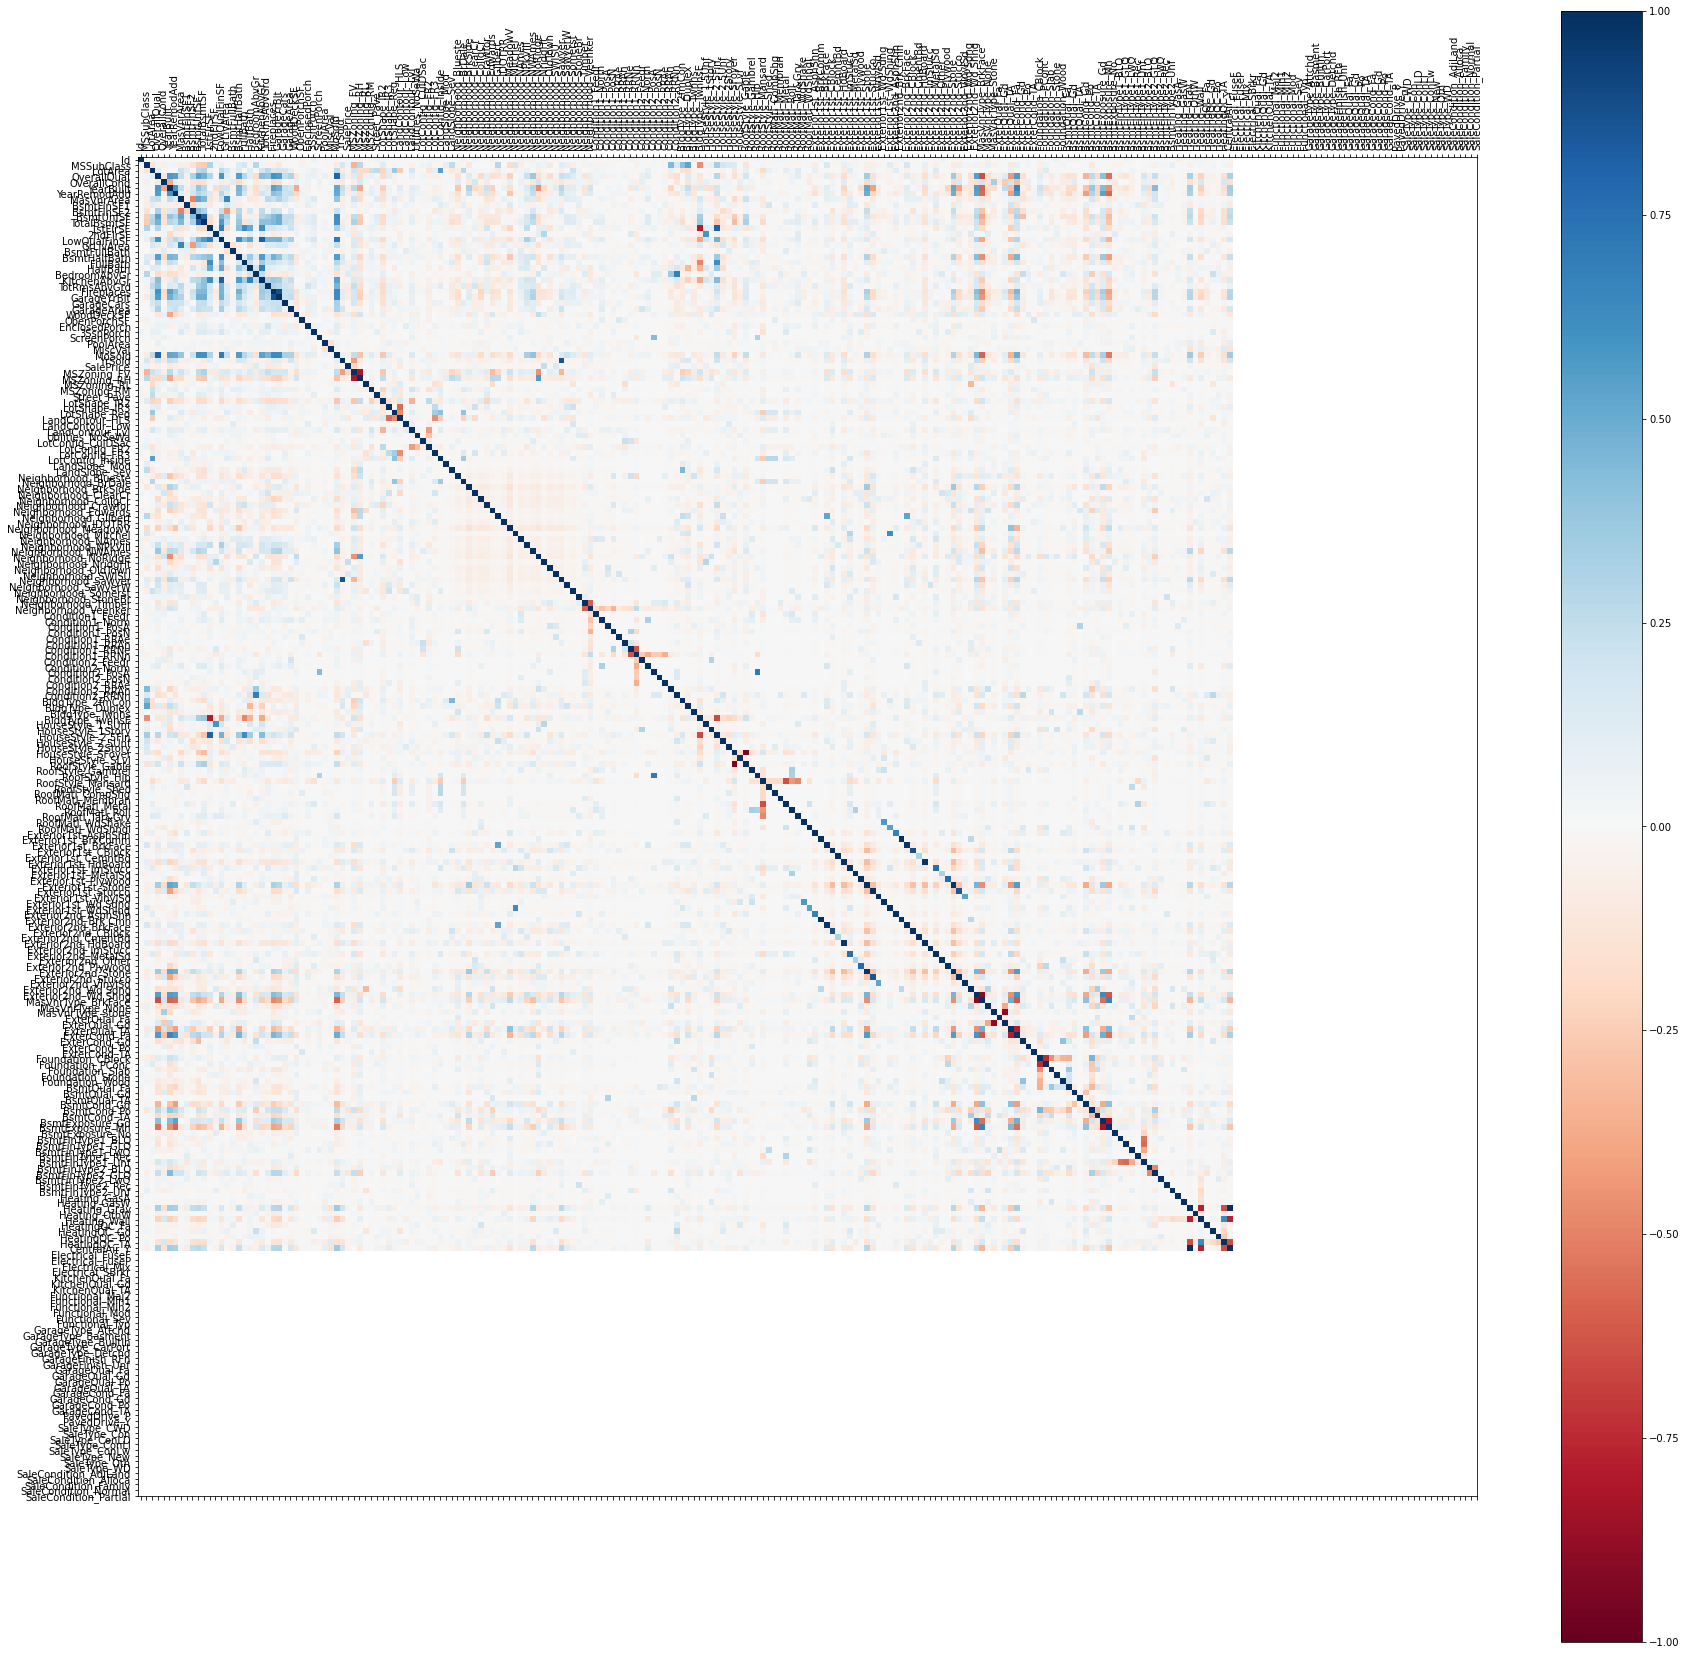

In [77]:
corr = df_train_filled.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='RdBu', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(df_train_filled.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(df_train_filled.columns)
ax.set_yticklabels(df_train_filled.columns)
fig.set_size_inches(30, 30)
plt.show()

#todo: why last rows does not appear in the correlation graph and matrix

In [ ]:
#todo: check if the correlation with dummies are meaningful

corr=df_train_filled.corr().abs()




In [82]:
#Selecting lower triangle without diagonal and removing variables with more than 50% correlations with other predictors
corr=corr.where(np.tril(np.ones(corr.shape),-1).astype(np.bool))
corr_50=corr[corr.columns[corr.max()<0.5]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [84]:
corr

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MSSubClass,0.011156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LotArea,0.033226,0.139781,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OverallQual,0.028365,0.032628,0.105806,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OverallCond,0.012609,0.059316,0.005636,0.091932,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SaleCondition_AdjLand,0.034852,0.016241,0.013208,0.041677,0.038888,0.045601,0.040294,0.014874,0.015130,0.034618,...,0.003073,0.003073,0.015827,0.002378,0.020457,NaN,NaN,NaN,NaN,NaN
SaleCondition_Alloca,0.009018,0.030002,0.008966,0.044950,0.033444,0.010104,0.020727,0.021369,0.026277,0.059130,...,0.005337,0.005337,0.027489,0.004131,0.035530,0.004772,NaN,NaN,NaN,NaN
SaleCondition_Family,0.004865,0.000983,0.010781,0.025515,0.023873,0.035785,0.048056,0.000765,0.007929,0.021534,...,0.006909,0.006909,0.035587,0.005348,0.028599,0.006177,0.010729,NaN,NaN,NaN
SaleCondition_Normal,0.015881,0.024359,0.005711,0.143282,0.161642,0.158427,0.120577,0.019560,0.041207,0.153930,...,0.003139,0.027414,0.645698,0.097031,0.634322,0.112080,0.194663,0.252006,NaN,NaN


In [ ]:
SalePrice_and_LotFrontage_model = smf.ols(formula='SalePrice ~ LotFrontage', data=df)
SalePrice_and_LotFrontage_fit = SalePrice_and_LotFrontage_model.fit()
print(SalePrice_and_LotFrontage_fit.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     169.4
Date:                Fri, 07 Oct 2022   Prob (F-statistic):           2.60e-36
Time:                        16:48:24   Log-Likelihood:                -15233.
No. Observations:                1201   AIC:                         3.047e+04
Df Residuals:                    1199   BIC:                         3.048e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    9.615e+04   6881.966     13.971      

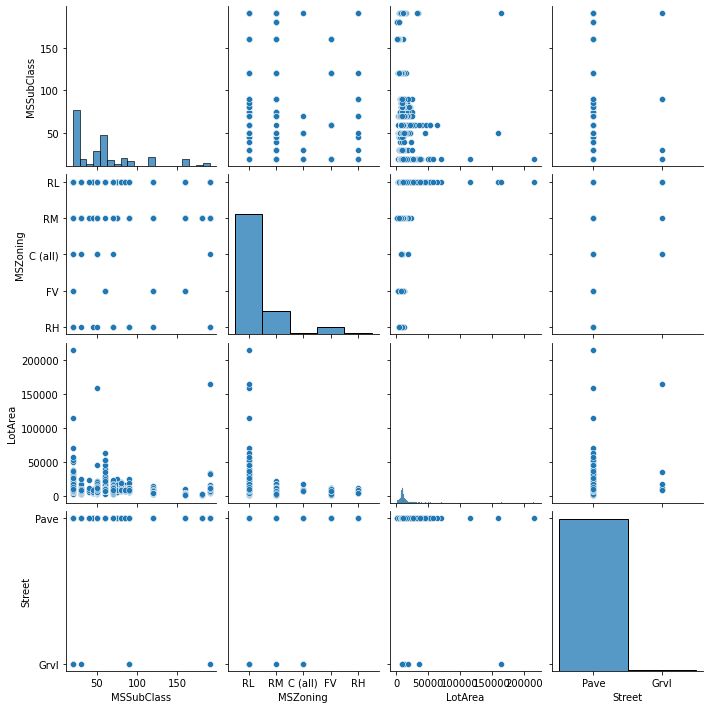

In [ ]:
sns.pairplot(df_train_nona, vars=df_train_nona.columns[1:5]);

# Executive Summary
